<a href="https://colab.research.google.com/github/aquapathos/MLLesson/blob/master/PPOSB3v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable baselines3 のインストール
Monitor() を改変したいので、ソースからインストール。

In [1]:
%%bash
git clone https://github.com/DLR-RM/stable-baselines3.git > /dev/null
cd stable-baselines3 
pip -q install -e . 

fatal: destination path 'stable-baselines3' already exists and is not an empty directory.


stable-baselines3/stable_baselines3/common/monitor.py に次の2行を追加して保存（Cntrl+S)、ランタイムを再起動

<img width="473" alt="Monitor" src="https://user-images.githubusercontent.com/5820803/104115466-079c3200-5353-11eb-97b9-a9386345008c.png">



In [2]:
# !pip install stable-baselines3[extra] > /dev/null   <- これでインストールできるが、monitor_kwargs が使えないため
!pip install wandb > /dev/null

# Google Drive をマウント　モデル保存用

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ライブラリ準備

In [1]:
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import DummyVecEnv,SubprocVecEnv,VecFrameStack
from stable_baselines3 import PPO
import wandb,os
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image 
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(repr(device))

# Load the TensorBoard notebook extension テンソルボードも使えるが、WandBを使うことにするので、封印
#%load_ext tensorboard
#%tensorboard --logdir ./logsP --host 0.0.0.0
log_dir = "/content/drive/MyDrive/M/logsP2/"
#!rm -fr /content/drive/MyDrive/M/logsP2/*

device(type='cpu')


# 基本

- [env_utils](https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/common/env_util.py) 
- [atari_wrappers.py](https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/common/atari_wrappers.py)

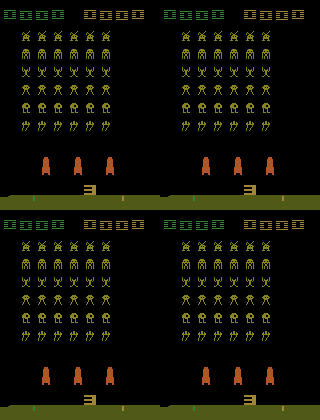

In [2]:
# インベーダ monitor_kwargs={'allow_early_resets':True}
env_id = 'SpaceInvadersNoFrameskip-v4'
env = make_atari_env(env_id, n_envs=4, seed=0,vec_env_cls=DummyVecEnv, wrapper_kwargs = {}, monitor_dir= log_dir,monitor_kwargs={'allow_early_resets':True})
#env = make_atari_env(env_id, n_envs=1, seed=0,vec_env_cls=SubprocVecEnv, wrapper_kwargs = {}, monitor_dir= log_dir)
Image.fromarray((env.render(mode='rgb_array')))

# インベーダゲームのAction Spaceについて

 'SpaceInvadersNoFrameskip-v4'のアクションスペースは、なぜか、Discrete(6)である。  
 Atariゲーム一般のアクション番号の意味は、[openai gym のソース](https://github.com/openai/gym/blob/master/gym/envs/atari/atari_env.py)を見ると、


 ACTION_MEANING = { 0: "NOOP", 1: "FIRE", 2: "UP", 3: "RIGHT", 4: "LEFT", 5: "DOWN", 6: "UPRIGHT", 7: "UPLEFT", 8: "DOWNRIGHT", 9: "DOWNLEFT", 10: "UPFIRE", 11: "RIGHTFIRE", 12: "LEFTFIRE", 13: "DOWNFIRE", 14: "UPRIGHTFIRE", 15: "UPLEFTFIRE", 16: "DOWNRIGHTFIRE", 17: "DOWNLEFTFIRE", }

 と定義されていて、５までだと、UP,DOWNが含まれることになる。

env.unwrapped.get_action_meanings() で割り当てを調べてみると、

In [3]:
import gym
print(env.action_space)
gym.make(env_id).unwrapped.get_action_meanings() 

Discrete(6)


['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

となっており、デフォルトの意味割り当てと違っているのがわかる。４，５は移動しながらのFIREが割り当てられているわけだが、簡単のためとネットのサイズを小さくするために、０～３を使うのが一般的。

[0. 1. 0. 0.] [False False False False] [{'ale.lives': 3}, {'ale.lives': 3}, {'ale.lives': 3}, {'ale.lives': 3}]
[0. 0. 1. 0.] [False False False False] [{'ale.lives': 3}, {'ale.lives': 3}, {'ale.lives': 3}, {'ale.lives': 3}]
[0. 0. 1. 0.] [False False False False] [{'ale.lives': 3}, {'ale.lives': 3}, {'ale.lives': 3}, {'ale.lives': 3}]
[0. 1. 0. 0.] [False False False False] [{'ale.lives': 3}, {'ale.lives': 3}, {'ale.lives': 3}, {'ale.lives': 3}]
[0. 0. 0. 1.] [False False False False] [{'ale.lives': 3}, {'ale.lives': 3}, {'ale.lives': 3}, {'ale.lives': 3}]
[0. 1. 0. 0.] [False False False False] [{'ale.lives': 3}, {'ale.lives': 3}, {'ale.lives': 3}, {'ale.lives': 3}]
[0. 0. 1. 0.] [False False False False] [{'ale.lives': 3}, {'ale.lives': 3}, {'ale.lives': 3}, {'ale.lives': 3}]


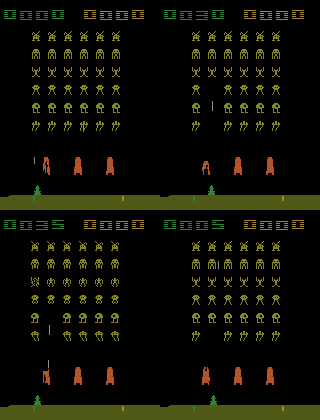

(None, '総報酬=', array([1., 4., 4., 2.], dtype=float32))

In [4]:
model = PPO('CnnPolicy', env, verbose=0)

rs = 1
obs = model.env.reset()
for i in range(100):
  action, _ = model.predict(obs)
  obs, r, d ,i = model.env.step(action)
  if sum(r) != 0:
    rs += r
    print(r,d,i)
cv2_imshow(env.render(mode='rgb_array')[:,:,::-1]),"総報酬=",rs

 make_atari_env() で作成した環境はデフォルトで **env = ClipRewardEnv(env)** でラップされているため、報酬はスコアではなくヒットした回数になっている。ただし、Monitor で記録されるのは、生のスコア。 

In [5]:
# Inside my model training code 
!export WANDB_NOTEBOOK_NAME="SB3.ipynb"
import wandb
PROJECTNAME='SB3Inv'
wandb.init(project=PROJECTNAME)

wandb: Currently logged in as: aquapathos (use `wandb login --relogin` to force relogin)


In [ ]:
env_id = 'SpaceInvadersNoFrameskip-v4'
wrapper_kwargs = {'frame_skip':2,'terminal_on_life_loss':True,'clip_reward':True} 
#env = make_atari_env(env_id, n_envs=8, seed=0,vec_env_cls=SubprocVecEnv, monitor_dir= log_dir,wrapper_kwargs = wrapper_kwargs)
env = make_atari_env(env_id, n_envs=8, seed=0,vec_env_cls=DummyVecEnv, wrapper_kwargs=wrapper_kwargs, monitor_dir= log_dir)
env = VecFrameStack(env, n_stack=6)

# 最適パラメータ https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/ppo.yml
model = PPO('CnnPolicy', env, verbose=0,device=device,        
    learning_rate = 2.5e-4,  # default  3e-4
    n_steps = 128, # 2048
    clip_range = 0.1, # default 0.2
    ent_coef = 0.01, # default 0.0
    batch_size = 256, #64
    n_epochs = 4 )

total_timesteps = 1e7
%time model.learn(total_timesteps=total_timesteps)
# 追加学習
#%time model.learn(total_timesteps=total_timesteps, reset_num_timesteps=False)

# 結果を動画化

In [ ]:
import imageio
import numpy as np

model.load("/content/drive/MyDrive/M/logsP/SpaceInvadersBest_model")
#env8 = make_atari_env('SpaceInvadersNoFrameskip-v4', n_envs=8, seed=0,vec_env_cls=SubprocVecEnv, monitor_dir= log_dir)
env = make_atari_env('SpaceInvadersNoFrameskip-v4', n_envs=8, seed=0,vec_env_cls=DummyVecEnv, monitor_dir= log_dir)
env = VecFrameStack(env, n_stack=4)
model.set_env(env8)

images = []
obs = model.env.reset()
img = model.env.envs[0].render(mode='rgb_array')
for i in range(1800):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)
    img = model.env.envs[0].render(mode='rgb_array')

#imageio.mimsave('/SpaceInvadersBes.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

Wrapping the env in a VecTransposeImage.


In [ ]:
frame_rate = 30.0  #FPS
def timelaps(images,width,height):
    fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
    video = cv2.VideoWriter('inveders.mp4', fourcc, frame_rate, (width, height))
    for img in images:
        video.write(img[:,:,::-1]) 
    video.release()
    print("動画変換完了")

In [ ]:
timelaps(images,160,210)

動画変換中...
動画変換完了


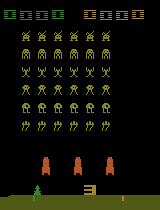

(None, 600)

In [ ]:
cv2_imshow(images[0][:,:,::-1]),len(images)

In [ ]:
import imageio
import numpy as np

model.load("/content/drive/MyDrive/M/logsP/SpaceInvadersBest_model")
#env8 = make_atari_env('SpaceInvadersNoFrameskip-v4', n_envs=8, seed=0,vec_env_cls=SubprocVecEnv, monitor_dir= log_dir)
env8 = make_atari_env('SpaceInvadersNoFrameskip-v4', n_envs=8, seed=0,vec_env_cls=DummyVecEnv, monitor_dir= log_dir)
env8 = VecFrameStack(env8, n_stack=4)
model.set_env(env8)

images = []
obs = model.env.reset()
img = model.env.render(mode='rgb_array')[:420,:320]
for i in range(1800):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)
    img = model.env.render(mode='rgb_array')[:420,:320]

#imageio.mimsave('/SpaceInvadersBes.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

Wrapping the env in a VecTransposeImage.


In [ ]:
timelaps(images,320,420)

動画変換中...
動画変換完了
